In [31]:
import sys
import numpy as np
import pandas as pd 
import os

from glob import glob
from typing import Tuple

import matplotlib.pyplot as plt

sys.path.insert(0, '../')

from pickle import load, dump
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn. metrics import r2_score

from src.vg2signal import read_raw_vg_as_df, make_smoother, make_shoulder_getter, make_detilter
from src.utils  import per_error
from src.config import DATASET_PATH

In [32]:
# Load Data set
# Testing only on ML1 and ML2 dataset
def v2signal_extra_features(vg_filename: str,
             do_log: bool,
             smoothing_bw: float,
             vcenter: float,
             vwidth: float,
             stiffness: float):

    vg_df = read_raw_vg_as_df(vg_filename)

    if (vg_df['I'].to_numpy() < 0).any():
        temp = [None] * 11
        return [None, None, vg_df] + temp

    if do_log:
        cur_var_name = "logI"
        #vg_df[cur_var_name] = np.emath.logn(logbase, vg_df["I"])
        vg_df[cur_var_name] = np.log2(vg_df["I"])
    else:
        cur_var_name = "I"

    smoother = make_smoother(smoothing_bw)

    vg_df["smoothed"] = smoother(vg_df["V"], vg_df[cur_var_name].to_numpy())

    shoulder_getter = make_shoulder_getter(1, 1.1)
    (peak_signal, peak_v_shoulder) = shoulder_getter(vg_df["V"],
                                                     vg_df["smoothed"])

    vcenter = peak_v_shoulder
    vstart = vcenter - 0.5*vwidth
    vend = vcenter + 0.5*vwidth

    detilter = make_detilter(vstart, vend, stiffness)
    vg_df["detilted"] = detilter(vg_df["V"].to_numpy(),
                                 vg_df["smoothed"].to_numpy())

   
    return  vg_df

def run_vg2_raw(folderpath: str, 
            do_log:bool, 
            recenter:bool, 
            smoothing_bw:float, 
            stiffness:float, 
            vcenter:float, 
            vwidth1:float, 
            vwidth2:float) -> Tuple[dict, str]:

    os.chdir(folderpath)  # change to desired folderpath
    dfxl     = pd.DataFrame(columns=['labels', 'VI'])
    
    for filename in os.listdir():
        if filename[-3:] == 'txt':
            print("Analyzing:", filename)
            df = v2signal_extra_features(filename,
                                        do_log,
                                        smoothing_bw,
                                        vcenter,
                                        vwidth1,
                                        stiffness)

            idx1 = filename.rfind("cbz")
            idx2 = filename[idx1:].find("_")
            conc = filename[idx1 + 3:idx1 + idx2]
            replicate = filename[idx1 + idx2 + 1:filename.rfind(".")]

            # Crop only the signal
            try:
                crop = (df['V']<1.15) & (df['V']>0.93)
                VI   =  df['detilted'][crop].to_numpy() 
            except:
                continue

            if 'p' in conc:  
                pi = conc.find('p')
                conctemp = conc[:pi] + '.' + conc[pi + 1:]
                conc = conctemp
            
            concstrxl   = str(float(conc))
            dfxl = pd.concat([dfxl, pd.DataFrame({'labels':concstrxl, 'VI':[VI]})])

    with open(f"{folderpath}/raw_data.pickle", 'wb') as f:
        dump(dfxl, f)
   
    return    dfxl  

def load_dataset(dataset_path=None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    if dataset_path==None: dataset_path = DATASET_PATH

    if ('ML1_ML2'in os.path.basename(dataset_path)) or ('test' in os.path.basename(dataset_path)):
        datasets = sorted([f"{i}/raw_data.pickle" for i in glob(f'{dataset_path}/*')])
        
        df = []
        for dataset in datasets:

            with open(dataset, 'rb') as f:
                data = load(f)
                df.append(data) 
        df = pd.concat(df)

    else:
        dataset_path = f"{dataset_path}/raw_data.pickle"
        with open(dataset_path, 'rb') as f:
            df = load(f)

    X = [x.iloc[0] for (_,x) in df[['VI']].iterrows()] 
    X = np.array(X)
    y = df['labels'].apply(lambda x: float(x))

    # Split the total dataset into training (60%) and testing (40%) dataset
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=20, stratify=y)

    return (X_train, X_test, y_train, y_test), (X, y)

In [33]:
all_dataset = glob('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4/')
    
do_log   = True
recenter = False
bw       = 0.006
s        = 0
c        = 1.04
w1       = 0.15
w2       = 0.17

print(all_dataset)
for dataset_path in all_dataset:
    print(dataset_path)
    data = run_vg2_raw(dataset_path, do_log, recenter, bw, s, c, w1, w2)

['/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4/']
/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4/
Analyzing: 2024_03_08_cbz08_46.txt
Analyzing: 2024_03_08_cbz16_46.txt
Analyzing: 2024_03_08_cbz00_22.txt
Analyzing: 2024_03_08_cbz00_36.txt
Analyzing: 2024_03_08_cbz00_37.txt
Analyzing: 2024_03_08_cbz00_23.txt
Analyzing: 2024_03_08_cbz16_47.txt
Analyzing: 2024_03_08_cbz08_47.txt
Analyzing: 2024_03_08_cbz08_45.txt
Analyzing: 2024_03_08_cbz16_45.txt
Analyzing: 2024_03_08_cbz00_09.txt
Analyzing: 2024_03_08_cbz00_35.txt
Analyzing: 2024_03_08_cbz00_21.txt
Analyzing: 2024_03_08_cbz00_20.txt
Analyzing: 2024_03_08_cbz00_34.txt
Analyzing: 2024_03_08_cbz00_08.txt
Analyzing: 2024_03_08_cbz16_44.txt
Analyzing: 2024_03_08_cbz08_44.txt
Analyzing: 2024_03_08_cbz08_40.txt
Analyzing: 2024_03_08_cbz16_40.txt
Analyzing: 2024_03_08_cbz00_30.txt
Analyzing: 2024_03_08_cbz00_24.txt
Analyzing: 2024_03_08_cbz00_18.txt
Analyzing: 2024_03_08_cbz00_19.txt
Analyzing: 2024_03_08_cbz00_25.txt
Ana

In [34]:
(X_train, X_test, y_train, y_test), (X, y) = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2')
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

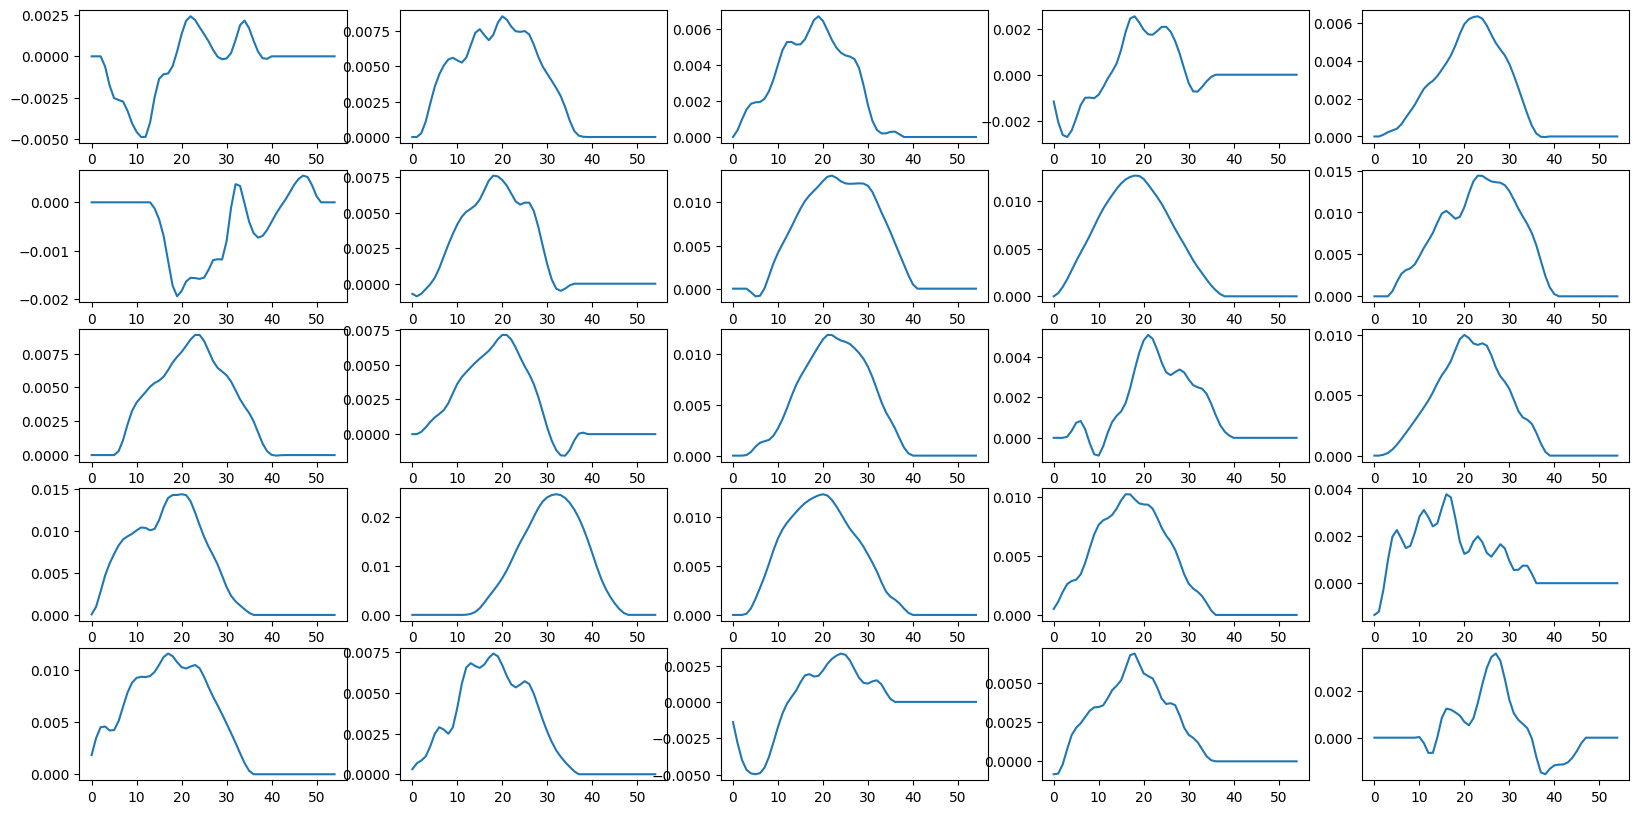

In [35]:

fig, axes = plt.subplots(5, 5, figsize=(20, 10))

for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        ax.plot(blank_data_analysis[i*5+j])  # Plot random data

plt.savefig('../blank_raw_ML4.png', dpi=300)

In [36]:
gp_model = GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=2.5), alpha=1)

In [26]:
gp_model.fit(X_train, y_train)

/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=1, kernel=1**2 * RBF(length_scale=2.5))

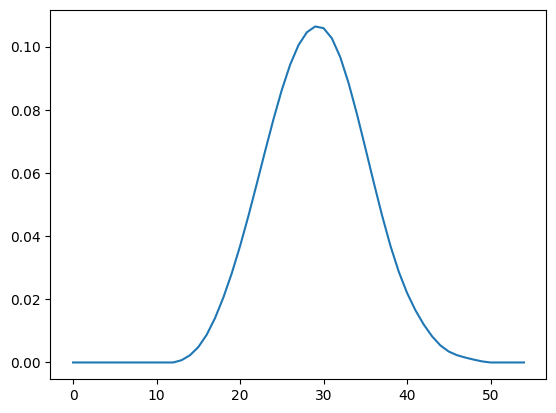

In [38]:
plt.plot(X_train[4])

In [28]:
y_pred = gp_model.predict(X_test)

In [29]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
r2_score(y_test, y_pred)

-1.4558823529411766